## inference in simple model using synthetic data
population size 10^6

we run several independent computations on different data sets, as a test of whether inferred parameters are reliable

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
import os
import pickle
import pprint
import time

import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

import synth_fns

(cell 3 was removed to hide local file info)
### main settings

In [4]:
## for dataFiles : needs a fresh value in every notebooke
#fileRoot = 'dataSynthInfQuality-pop1e6'

## we can run this notebook several times to gets lots of data...
runID = 0
fileRoot = 'dataSynthInfQuality-pop1e6-run{r:d}'.format(r=runID)

## total population
popN = 1e6

## tau-leaping param, take this negative to force gillespie
## or set a small value for high-accuracy tau-leap (eg 1e-4 or 1e-5)
leapEps = -1

## do we use small tolerances for the likelihood computations? (use False for debug etc)
isHighAccuracy = True

# absolute tolerance for logp for MAP 
inf_atol = 0.1

## prior mean of beta, divided by true value (set to 1.0 for the simplest case)
betaPriorOffset = 1.0
betaPriorLogNorm = False

## mcmc
mcSamples = 5000
nProcMCMC = 2 # None ## take None to use default but large numbers are not efficient in this example

## how many synthetic trajectories
nTraj = 8

### model

In [5]:
model_dict = synth_fns.get_model(popN)

model_spec = model_dict['mod']
contactMatrix = model_dict['CM']
parameters_true = model_dict['params']
cohortsM = model_dict['cohortsM']
Ni = model_dict['cohortsPop']

trajSeed = 18+(nTraj*runID)
infSeed = 21+(nTraj*runID)

#### more settings

In [6]:
## total trajectory time (bare units)
Tf_bare = 20
## total inf time
Tf_inf_bare = 5

## inference period starts when the total deaths reach this amount (as a fraction)
fracDeaths = 2e-3 # int(N*200/1e5)


In [7]:
## hack to get higher-frequency data
## how many data points per "timestep" (in original units)
fineData = 4

## this assumes that all parameters are rates !!
for key in parameters_true:
    #print(key,parameters_true[key])
    parameters_true[key] /= fineData

Tf = Tf_bare * fineData;  
Nf = Tf+1

Tf_inference = Tf_inf_bare * fineData
Nf_inference = Tf_inference+1

### plotting helper functions

In [8]:
def plotTraj(M,data_array,Nf_start,Tf_inference,fineData):
    fig = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    t = np.linspace(0, Tf/fineData, Nf)

    # plt.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='S', lw=4)
    plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-o', label='Exposed', lw=2)
    plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-o', label='Infected', lw=2)
    plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-o', label='Deaths', lw=2)
    #plt.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=2)

    plt.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    plt.legend()
    plt.show()

    fig,axs = plt.subplots(1,2, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    ax = axs[0]
    ax.plot(t[1:],np.diff(np.sum(data_array[:, 3*M:4*M], axis=1)),'o-',label='death increments', lw=1)
    ax.legend(loc='upper right') ; # plt.show()

    ax = axs[1]
    ax.plot(t,np.sum(data_array[:, 3*M:4*M], axis=1),'o-',label='deaths',ms=3)
    ax.legend() ; 

    plt.show()


def plotMAP(res,data_array,M,N,estimator,Nf_start,Tf_inference,fineData):
    print('**beta(bare units)',res['params_dict']['beta']*fineData)
    print('**logLik',res['log_likelihood'],'true was',logpTrue)
    print('\n')
    print(res)

    fig,axs = plt.subplots(1,3, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust(wspace=0.3)
    #plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    t = np.linspace(0, Tf/fineData, Nf)

    ax = axs[0]

    #plt.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='S', lw=4)
    ax.plot(t, np.sum(data_array[:, M:2*M], axis=1), 'o', label='Exposed', lw=2)
    ax.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), 'o', label='Infected', lw=2)
    ax.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), 'o', label='Deaths', lw=2)
    #plt.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=2)

    tt = np.linspace(Nf_start, Tf, Nf-Nf_start,)/fineData
    xm = estimator.integrate(res['x0'], Nf_start, Tf, Nf-Nf_start, dense_output=False)
    #plt.plot(tt, np.sum(xm[:, :M], axis=1), '-x', label='S-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, M:2*M], axis=1), '-x', color='C0',label='E-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, 2*M:3*M], axis=1), '-x', color='C1',label='I-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, 3*M:4*M], axis=1), '-x', color='C2',label='D-MAP', lw=2, ms=3)
    #plt.plot(tt, N-np.sum(xm[:, :4*M], axis=1), '-o', label='R-MAP', lw=2)

    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()

    ax = axs[1]
    ax.plot(t[1:], np.diff(np.sum(data_array[:, 3*M:4*M], axis=1)), '-o', label='death incs', lw=2)
    ax.plot(tt[1:], np.diff(np.sum(xm[:, 3*M:4*M], axis=1)), '-x', label='MAP', lw=2, ms=3)
    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()

    ax = axs[2]

    ax.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='Sus', lw=1.5, ms=3)
    #plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-o', label='Exposed', lw=2)
    #plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-o', label='Infected', lw=2)
    #plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-o', label='Deaths', lw=2)
    ax.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=1.5, ms=3)

    #infResult = res
    tt = np.linspace(Nf_start, Tf, Nf-Nf_start,)/fineData
    xm = estimator.integrate(res['x0'], Nf_start, Tf, Nf-Nf_start, dense_output=False)
    ax.plot(tt, np.sum(xm[:, :M], axis=1), '-x', label='S-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, M:2*M], axis=1), '-x', label='E-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, 2*M:3*M], axis=1), '-x', label='I-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, 3*M:4*M], axis=1), '-x', label='D-MAP', lw=2, ms=3)
    ax.plot(tt, N-np.sum(xm[:, :4*M], axis=1), '-x', label='R-MAP', lw=1.5, ms=3)

    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()
    plt.show()
    

    
def plotMCtrace(selected_dims, sampler, numTrace=None):
    # Plot the trace for these dimensions:
    plot_dim = len(selected_dims)
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(plot_dim, figsize=(12, plot_dim), sharex=True)
    samples = sampler.get_chain()
    if numTrace == None : numTrace = np.shape(samples)[1]  ## corrected index
    for ii,dd in enumerate(selected_dims):
        ax = axes[ii]
        ax.plot(samples[:, :numTrace , dd], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
    axes[-1].set_xlabel("step number");
    plt.show(fig)
    plt.close()

def plotPosteriors(estimator,obsData, fltrDeath, Tf_inference,param_priors, init_priors,contactMatrix,
                   infResult,parameters_true,trueInit,rangeParam=0.5) :
    ## used for prior pdfs
    (likFun,priFun,dimFlat) = pyross.evidence.latent_get_parameters(estimator,
                                        obsData, fltrDeath, Tf_inference,
                                        param_priors, init_priors,                                   
                                        contactMatrix,
                                        #intervention_fun=interventionFn,
                                        tangent=False,
                                      )
    xVals = np.linspace(parameters_true['beta']*(1-rangeParam),parameters_true['beta']*(1+rangeParam),100)

    betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]
    plt.hist(betas,density=True,color='lightblue',label='posterior')
    yVal=2
    plt.plot([infResult['params_dict']['beta']],[yVal],'bs',label='MAP',ms=10)
    plt.plot([parameters_true['beta']],[yVal],'ro',label='true',ms=10)


    ## this is a bit complicated, it just finds the prior for beta from the infResult
    var='beta'
    jj = infResult['param_keys'].index(var)
    xInd = infResult['param_guess_range'][jj]
    #print(jj,xInd)
    pVals = []
    for xx in xVals :
        flatP = np.zeros( dimFlat )
        flatP[xInd] = xx
        pdfAll = np.exp( priFun.logpdf(flatP) )
        pVals.append( pdfAll[xInd] )
    plt.plot(xVals,pVals,color='darkgreen',label='prior')


    plt.xlabel(var)
    plt.ylabel('pdf')
    plt.legend()

    labs=['init S','init E','init I']
    nPanel=3
    fig,axs = plt.subplots(1,nPanel,figsize=(14,4))
    for ii in range(nPanel) :   
        ax = axs[ii]
        yVal=1.0/popN
        xs = [ rr['x0'][ii] for rr in result_mcmc ]
        ax.hist(xs,color='lightblue',density=True)
        ax.plot([infResult['x0'][ii]],yVal,'bs',label='true')
        ax.plot([trueInit[ii]],yVal,'ro',label='true')


        ## this is a bit complicated, it just finds the prior for beta from the infResult
        ## axis ranges
        xMin = np.min(xs)*0.8
        xMax = np.max(xs)*1.2
        xVals = np.linspace(xMin,xMax,100)

        ## this ID is a negative number because the init params are the end of the 'flat' param array
        paramID = ii-nPanel 
        pVals = []
        for xx in xVals :
            flatP = np.zeros( dimFlat )
            flatP[paramID] = xx
            pdfAll = np.exp( priFun.logpdf(flatP) )
            pVals.append( pdfAll[paramID] )
        ax.plot(xVals,pVals,color='darkgreen',label='prior')

        #plt.xlabel(var)
        ax.set_xlabel(labs[ii])
        ax.set_ylabel('pdf')
        ax.yaxis.set_ticklabels([])

    plt.show()


### run

trajSeed 19
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 19}
traj generation time 122.26810669898987 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=22, Mon May  3 22:19:51 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 1.292494928343137e+02 1.0e+00 9.90e-01  1e-02  3e+04 0:04.8
    2    128 1.369925006149892e+02 1.7e+00 9.58e-01  8e-03  3e+04 0:11.6
    3    192 1.224996019927926e+02 3.0e+00 9.04e-01  5e-03  2e+04 0:19.2
    4    256 1.287372848524281e+02 4.4e+00 9.11e-01  4e-03  2e+04 0:26.7
    5    320 1.255030646230748e+02 6.3e+00 9.47e-01  3e-03  2e+04 0:34.5
    6    384 1.225884091013580e+02 7.2e+00 1.00e+00  3e-03  2e+04 0:41.7
    7    448 1.221168216388654e+02 9.7e+00 9.61e-01  3e-03  2e+04 0:49.0
    8    512 1.224132018106373e+02 1.2e+01 9.16e-01  2e-03  2e+04 0:56.5
   10    640 1.21807

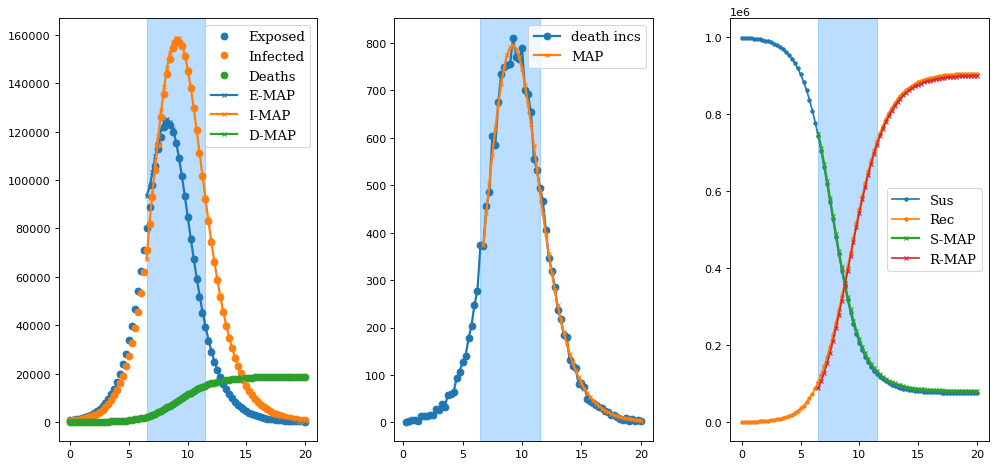

trajSeed 20
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 20}
traj generation time 134.0698926448822 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=23, Mon May  3 22:24:33 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 1.268744643111256e+02 1.0e+00 1.08e+00  1e-02  4e+04 0:07.2
    2    128 1.288827864468838e+02 1.7e+00 9.61e-01  8e-03  3e+04 0:12.9
    3    192 1.251195677377588e+02 2.6e+00 9.21e-01  6e-03  2e+04 0:17.8
    4    256 1.207100304264394e+02 4.0e+00 8.52e-01  4e-03  2e+04 0:22.6
    5    320 1.198236732503451e+02 5.8e+00 7.21e-01  3e-03  2e+04 0:27.4
    6    384 1.193226598602920e+02 7.7e+00 6.40e-01  2e-03  1e+04 0:34.2
    7    448 1.192319757676171e+02 8.4e+00 6.26e-01  2e-03  1e+04 0:41.5
    8    512 1.190998346058607e+02 1.2e+01 6.84e-01  2e-03  1e+04 0:48.7
   10    640 1.189789

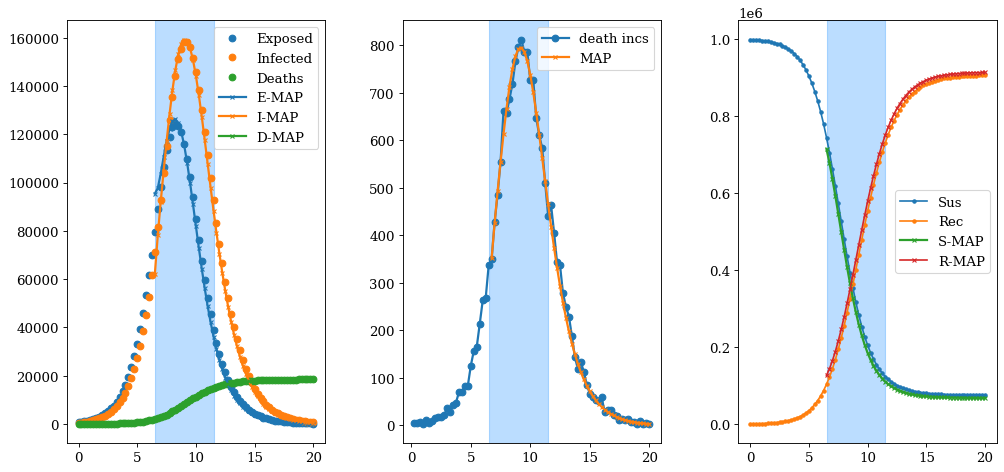

trajSeed 21
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 21}
traj generation time 116.77534675598145 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=24, Mon May  3 22:28:44 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 1.303195370721599e+02 1.0e+00 8.71e-01  1e-02  3e+04 0:07.1
    2    128 1.252369025375550e+02 1.8e+00 8.61e-01  7e-03  3e+04 0:14.6
    3    192 1.257388167711901e+02 2.7e+00 9.74e-01  6e-03  3e+04 0:21.6
    4    256 1.285321576196446e+02 4.7e+00 9.86e-01  6e-03  3e+04 0:28.9
    5    320 1.237657510139438e+02 6.3e+00 9.66e-01  5e-03  3e+04 0:36.3
    6    384 1.235657201542858e+02 8.7e+00 8.66e-01  3e-03  2e+04 0:43.6
    7    448 1.231537172867839e+02 9.7e+00 7.74e-01  2e-03  1e+04 0:50.9
    8    512 1.229825191199805e+02 1.2e+01 7.63e-01  2e-03  1e+04 0:58.3
   10    640 1.22780

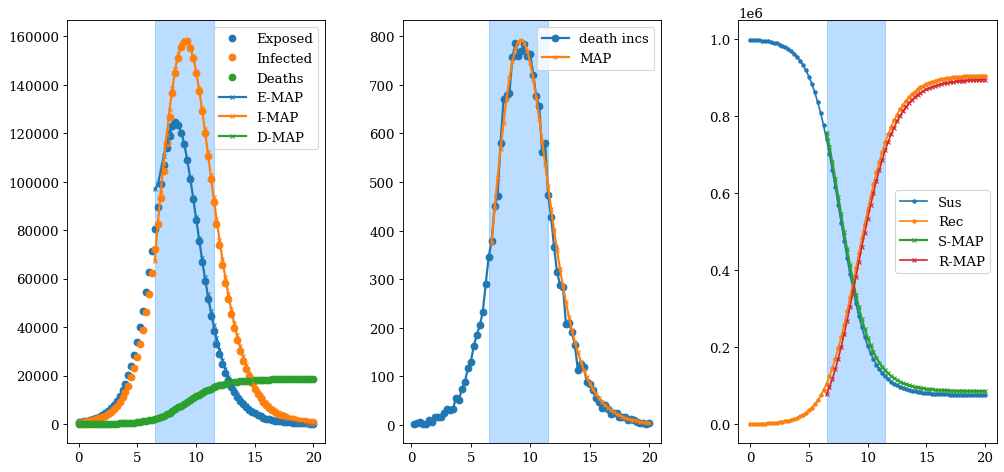

trajSeed 22
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 22}
traj generation time 78.86997151374817 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=25, Mon May  3 22:32:10 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 1.285967168665679e+02 1.0e+00 1.07e+00  1e-02  4e+04 0:05.1
    2    128 1.281507778763293e+02 1.9e+00 1.01e+00  9e-03  3e+04 0:10.3
    3    192 1.230163818970771e+02 2.6e+00 9.31e-01  6e-03  3e+04 0:15.7
    4    256 1.219391351628774e+02 3.8e+00 9.47e-01  6e-03  3e+04 0:20.9
    5    320 1.215152618469167e+02 6.7e+00 8.86e-01  4e-03  3e+04 0:26.0
    6    384 1.205619444742948e+02 7.9e+00 8.82e-01  3e-03  2e+04 0:31.2
    8    512 1.200624595130409e+02 1.1e+01 7.58e-01  2e-03  1e+04 0:41.2
   10    640 1.200043140068316e+02 1.3e+01 6.35e-01  8e-04  6e+03 0:51.3
   12    768 1.200000

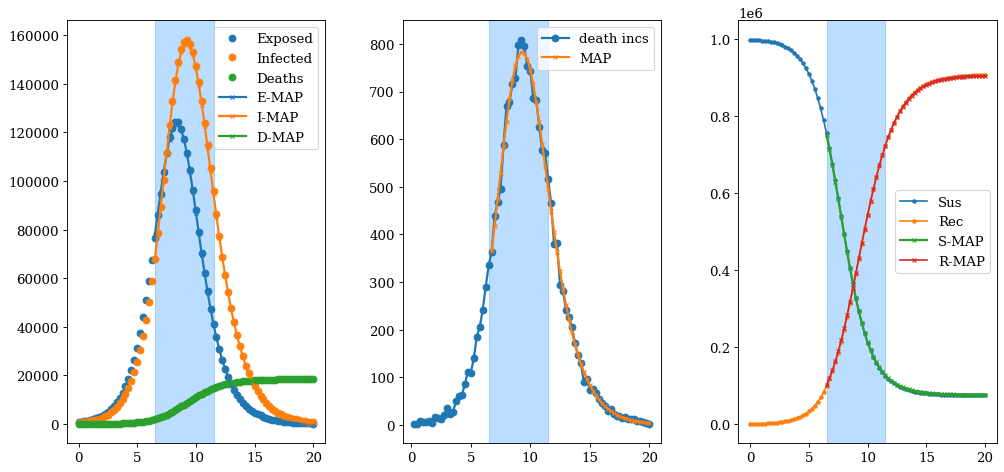

trajSeed 23
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 23}
traj generation time 75.91869950294495 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=26, Mon May  3 22:35:11 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 1.272946780475748e+02 1.0e+00 9.71e-01  1e-02  3e+04 0:05.1
    2    128 1.376681703555927e+02 1.8e+00 9.35e-01  8e-03  3e+04 0:10.5
    3    192 1.298797605122243e+02 3.0e+00 8.66e-01  6e-03  3e+04 0:15.7
    4    256 1.262744610175193e+02 4.6e+00 9.47e-01  5e-03  3e+04 0:20.9
    5    320 1.229946638762356e+02 5.4e+00 9.32e-01  4e-03  3e+04 0:26.2
    6    384 1.251494976731039e+02 8.0e+00 9.98e-01  3e-03  2e+04 0:31.4
    8    512 1.229548485920106e+02 1.4e+01 9.44e-01  2e-03  1e+04 0:41.8
   10    640 1.227887138466905e+02 1.3e+01 8.83e-01  1e-03  8e+03 0:52.3
   12    768 1.226940

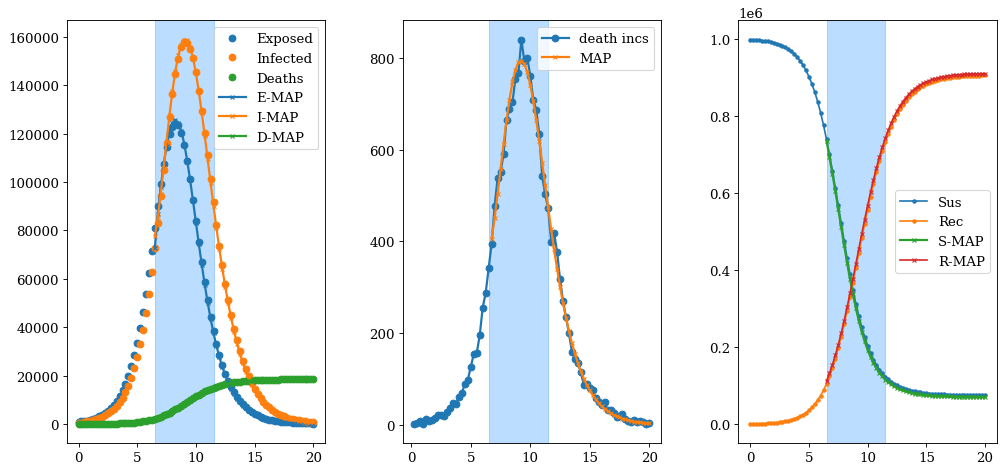

trajSeed 24
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 24}
traj generation time 76.21060943603516 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=27, Mon May  3 22:38:19 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 1.338064585266669e+02 1.0e+00 9.83e-01  1e-02  3e+04 0:04.9
    2    128 1.316480953515938e+02 1.7e+00 1.03e+00  8e-03  3e+04 0:10.1
    3    192 1.306171913795645e+02 2.8e+00 9.89e-01  6e-03  3e+04 0:15.2
    4    256 1.315768848254434e+02 4.3e+00 1.09e+00  5e-03  3e+04 0:20.5
    5    320 1.285883922048096e+02 6.5e+00 1.06e+00  4e-03  3e+04 0:25.6
    6    384 1.282246724776145e+02 7.7e+00 9.35e-01  3e-03  2e+04 0:30.8
    8    512 1.276896831574633e+02 1.1e+01 9.59e-01  2e-03  1e+04 0:41.2
   10    640 1.276050243270953e+02 1.4e+01 8.85e-01  1e-03  8e+03 0:51.6
   12    768 1.275842

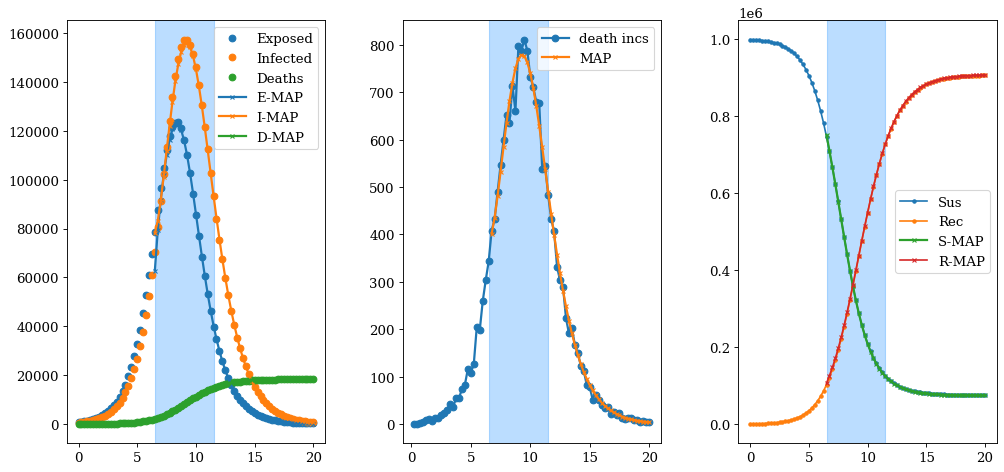

trajSeed 25
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 25}
traj generation time 74.75966572761536 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=28, Mon May  3 22:41:19 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 1.302681830777129e+02 1.0e+00 9.87e-01  1e-02  3e+04 0:05.1
    2    128 1.280042234136490e+02 1.8e+00 1.04e+00  8e-03  3e+04 0:10.0
    3    192 1.230645402961711e+02 3.2e+00 9.90e-01  6e-03  3e+04 0:15.1
    4    256 1.231187261315169e+02 4.9e+00 8.59e-01  4e-03  2e+04 0:20.4
    5    320 1.233872930528222e+02 7.0e+00 8.13e-01  4e-03  2e+04 0:25.5
    6    384 1.219936556983709e+02 9.3e+00 7.91e-01  3e-03  2e+04 0:30.6
    8    512 1.214235237520209e+02 1.3e+01 7.55e-01  2e-03  9e+03 0:41.3
   10    640 1.212691244178048e+02 1.4e+01 6.24e-01  9e-04  5e+03 0:51.6
   12    768 1.212091

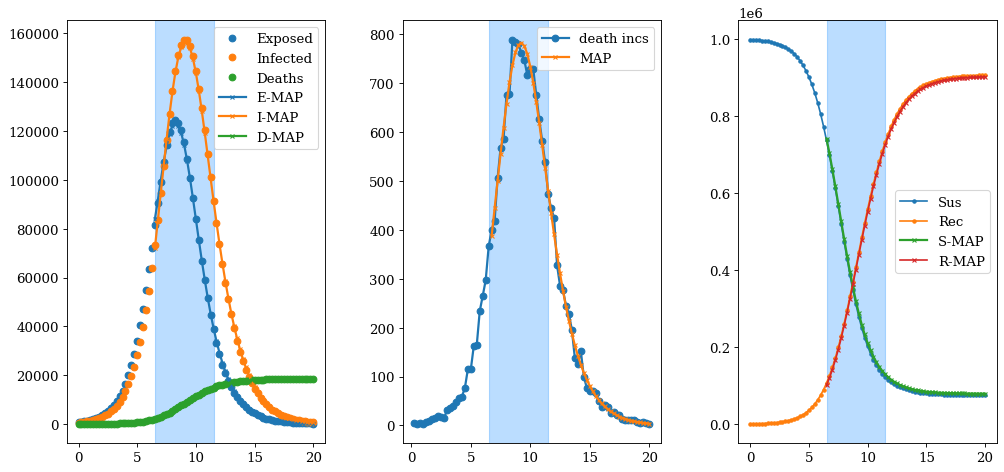

trajSeed 26
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 26}
traj generation time 79.91913294792175 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=29, Mon May  3 22:44:20 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 1.302267453261592e+02 1.0e+00 1.02e+00  1e-02  3e+04 0:05.1
    2    128 1.254327053201945e+02 1.8e+00 9.81e-01  8e-03  3e+04 0:10.2
    3    192 1.234210385344941e+02 3.2e+00 9.40e-01  6e-03  3e+04 0:15.4
    4    256 1.245088646021926e+02 4.9e+00 9.31e-01  5e-03  2e+04 0:20.5
    5    320 1.235129350852464e+02 5.8e+00 8.54e-01  4e-03  2e+04 0:25.8
    6    384 1.220301705812344e+02 7.3e+00 7.70e-01  3e-03  2e+04 0:31.0
    8    512 1.219067486184797e+02 1.0e+01 6.46e-01  1e-03  7e+03 0:41.1
   10    640 1.218544877966240e+02 1.4e+01 5.63e-01  8e-04  4e+03 0:51.4
   12    768 1.218432

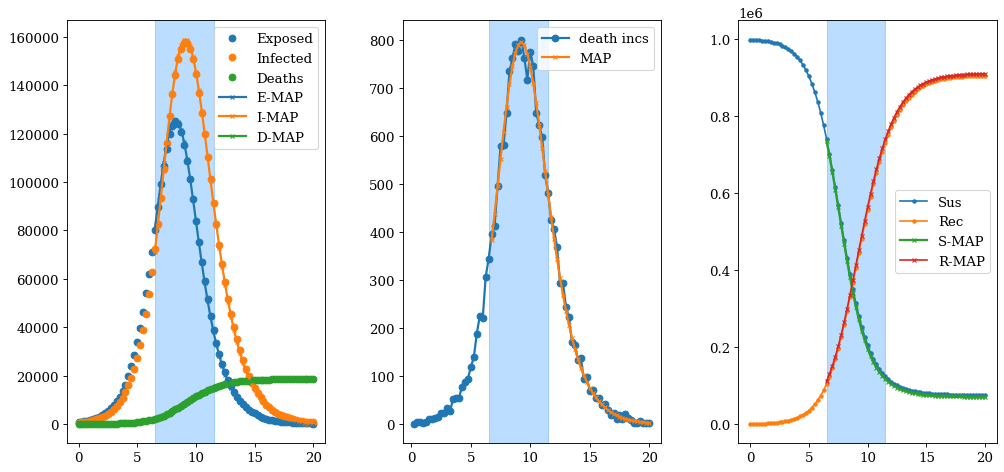

In [9]:
allData = []
allResultsInf = []

for trajIndex in range(nTraj) :
    
    trajSeed += 1
    infSeed += 1
    #mcSeed += 1
    print('trajSeed',trajSeed)
    
    ticTime = time.time()
    syntheticData = synth_fns.make_stochastic_traj(Tf,Nf,trajSeed,model_dict,leapEps)
    tocTime = time.time() - ticTime
    print('traj generation time',tocTime,'secs')

    np.save(fileRoot+'-stochTraj{s:d}.npy'.format(s=trajSeed),syntheticData)

    Nf_start = synth_fns.get_start_time(syntheticData, popN, fracDeaths)
    print('inf starts at timePoint',Nf_start)

    #plotTraj(cohortsM,syntheticData,Nf_start,Tf_inference,fineData)


    [estimator,fltrDeath,obsData,trueInit] = synth_fns.get_estimator(isHighAccuracy,model_dict,syntheticData, popN, Nf_start, Nf_inference,)

    allData += [obsData]
    
    ## compute log-likelihood of true params
    logpTrue = -estimator.minus_logp_red(parameters_true, trueInit, obsData, fltrDeath, Tf_inference, 
                                         contactMatrix, tangent=False)
    #print('**logLikTrue',logpTrue,'\n')

    #print('death data\n',obsData,'length',np.size(obsData),Nf_inference)

    [param_priors,init_priors] = synth_fns.get_priors(model_dict,betaPriorOffset,betaPriorLogNorm,fracDeaths,estimator)
    #print('Prior Params:',param_priors)
    #print('Prior Inits:')
    #pprint.pprint(init_priors)
    #print('trueBeta',parameters_true['beta'])
    #print('trueInit',trueInit)

    infResult = synth_fns.do_inf(estimator, obsData, fltrDeath, syntheticData, 
                                 popN, Tf_inference, infSeed, param_priors,init_priors, model_dict, inf_atol)

    allResultsInf += [infResult]
    
    #pprint.pprint(infResult)
    #print('MAP likelihood',infResult['log_likelihood'],'true',logpTrue)
    #print('MAP beta',infResult['params_dict']['beta'],'true',parameters_true['beta'])

    plotMAP(infResult,syntheticData,cohortsM,popN,estimator,Nf_start,Tf_inference,fineData)



In [10]:
mapBetas = np.array( [ rr['params_dict']['beta'] for rr in allResultsInf ] )
print(np.mean(mapBetas))
print(np.std(mapBetas))
print(mapBetas)

0.03494089979981443
0.0012428801384486874
[0.03364051 0.03666409 0.03268283 0.03500303 0.03598784 0.03543386
 0.03427375 0.03584128]


In [11]:
#assert False

traj 0 of 8
est map [3.36405135e-02 7.49319292e+05 9.34869904e+04 6.73438951e+04] 4


100%|██████████| 5000/5000 [2:00:18<00:00,  1.44s/it]  


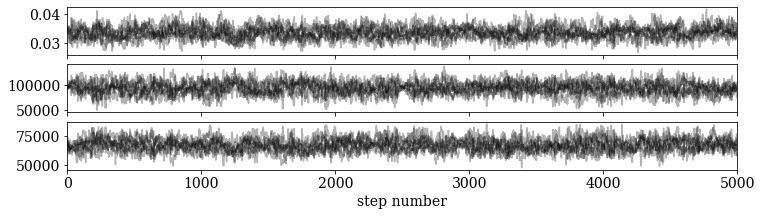

traj 1 of 8
est map [3.66640905e-02 7.14276168e+05 9.53939630e+04 6.21377584e+04] 4


100%|██████████| 5000/5000 [1:16:26<00:00,  1.09it/s]


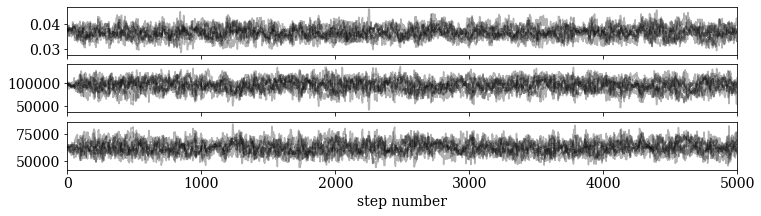

traj 2 of 8
est map [3.26828293e-02 7.56892114e+05 9.67860600e+04 6.71143083e+04] 4


100%|██████████| 5000/5000 [1:11:51<00:00,  1.16it/s]


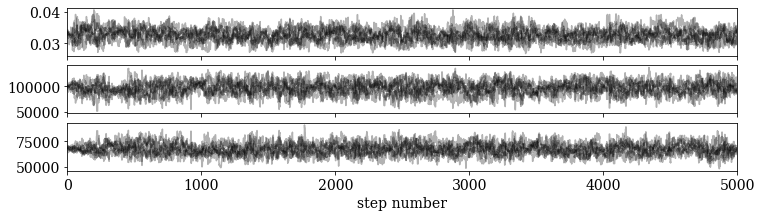

traj 3 of 8
est map [3.50030331e-02 7.50982206e+05 7.79497383e+04 6.77955185e+04] 4


100%|██████████| 5000/5000 [1:11:30<00:00,  1.17it/s]


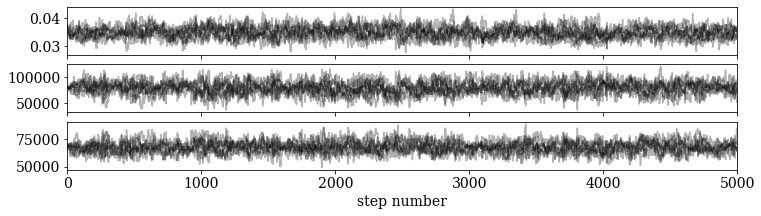

traj 4 of 8
est map [3.59878387e-02 7.35784884e+05 7.28196909e+04 7.76740251e+04] 4


100%|██████████| 5000/5000 [1:11:53<00:00,  1.16it/s]


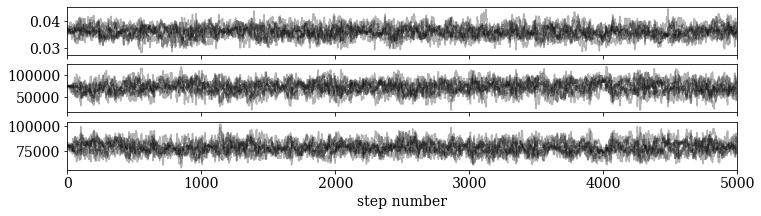

traj 5 of 8
est map [3.54338620e-02 7.50963880e+05 6.27888855e+04 7.81779472e+04] 4


100%|██████████| 5000/5000 [1:12:00<00:00,  1.16it/s]


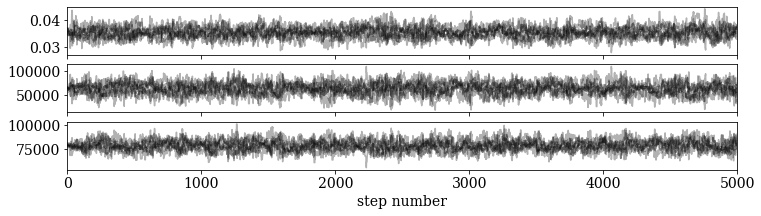

traj 6 of 8
est map [3.42737482e-02 7.41471627e+05 8.38019625e+04 7.18945874e+04] 4


100%|██████████| 5000/5000 [1:11:24<00:00,  1.17it/s]


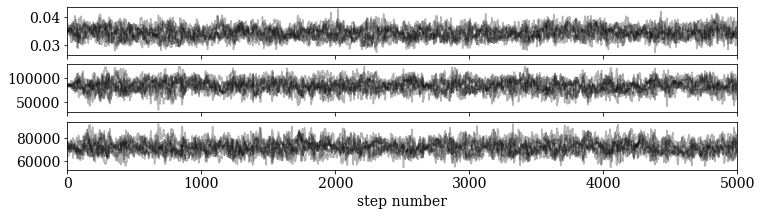

traj 7 of 8
est map [3.58412832e-02 7.35318231e+05 8.06437901e+04 7.12714163e+04] 4


100%|██████████| 5000/5000 [1:07:58<00:00,  1.23it/s]


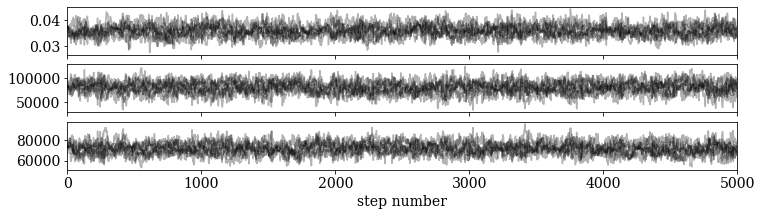

In [12]:
allResultsMC = []
for trajIndex,infResult in enumerate(allResultsInf) :
    print('traj',trajIndex,'of',len(allResultsInf))
    
    obsData = allData[ trajIndex ]
    
    sampler = synth_fns.do_mcmc(mcSamples, nProcMCMC, estimator, Tf_inference, infResult, 
                                obsData, fltrDeath, param_priors, init_priors, 
                                model_dict)
    plotMCtrace([0,2,3], sampler)
    result_mcmc = synth_fns.load_mcmc_result(estimator, obsData, fltrDeath, sampler, param_priors, init_priors, model_dict)
    allResultsMC += [result_mcmc]

### save MCMC data


In [13]:
opFile = fileRoot + "-mcmcAll.pik"
print('opf',opFile)
with open(opFile, 'wb') as f: 
    pickle.dump([allResultsInf,allResultsMC],f)

opf dataSynthInfQuality-pop1e6-run0-mcmcAll.pik


In [14]:
for trajIndex,result_mcmc in enumerate(allResultsMC) :
    betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]
    postMeanBeta = np.mean(betas)
    postStdBeta = np.std(betas)
    postCIBeta = [ np.percentile(betas,2.5) , np.percentile(betas,97.5)]

    #print("beta: true {b:.4f} MAP {m:.4f}".format(b=parameters_true['beta'],m=infResult['params_dict']['beta']))
    print("post: mean {m:.4f} std {s:.4f} CI95 {l:.4f} {u:.4f}".format(m=postMeanBeta,
                                                                     s=postStdBeta,
                                                                     l=postCIBeta[0],u=postCIBeta[1]))



post: mean 0.0336 std 0.0019 CI95 0.0301 0.0371
post: mean 0.0368 std 0.0022 CI95 0.0327 0.0414
post: mean 0.0326 std 0.0020 CI95 0.0291 0.0366
post: mean 0.0349 std 0.0022 CI95 0.0308 0.0390
post: mean 0.0360 std 0.0021 CI95 0.0319 0.0401
post: mean 0.0354 std 0.0021 CI95 0.0311 0.0396
post: mean 0.0343 std 0.0020 CI95 0.0304 0.0384
post: mean 0.0359 std 0.0021 CI95 0.0321 0.0398
